<a href="https://colab.research.google.com/github/splAcharya/Extractive_Text_Summarization/blob/main/ExTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extractive Text Summarization Of Wikipedia Articles

## Install Packages (if needed)

In [1]:
#gensim
!pip install --upgrade gensim

#rouge scorer
!pip install rouge-score

     |████████████████████████████████| 24.1 MB 1.9 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


## Import Required Libraries

In [1]:
import time
import re
import urllib.request
from bs4 import BeautifulSoup as bs

import string
pm_set = set(list(string.punctuation))

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
sw_set = set(stopwords.words("english"))

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
import gensim.downloader
from gensim.models import Phrases

import multiprocessing
num_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {num_cores}")

from wordcloud import WordCloud
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from sklearn.utils.extmath import randomized_svd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

from copy import deepcopy
from rouge_score import rouge_scorer
import pandas as pd
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Number of Cores: 2


## Function to Webscrape Wikipedia Article

In [24]:
def fetch_wikipedia_article(url="https://en.wikipedia.org/wiki/USA"):
    scrapped_data = urllib.request.urlopen(url)
    article = scrapped_data.read()
    parsed_article = bs(article,"lxml")
    paragraphs = parsed_article.find_all("p")
    article_text = ""
    for p in paragraphs:
        article_text += p.text
    return article_text

## Function to Pre-process Web Scraped Wikipedia Article

In [25]:
def preprocess_article(article, min_length = 5):
    article_lc = article.lower()#lower case entire article
    article_st = sent_tokenize(article_lc)#convert to sentences
    lmtzr = WordNetLemmatizer()#instantiate lemmatize
    pp_article_st = []
    final_article_st = []
    for sentence in article_st:
        original_sentence = deepcopy(sentence)
        #print(sentence)
        sentence = re.sub(r"[\(.*\)]"," ", sentence)#remove data betweena nd include round backers()
        #print(sentence)
        sentence = re.sub(r"\n","",sentence) #remove "\n" characters
        #print(sentence)
        sentence = re.sub(r"\[\d+\]"," ",sentence)#remove refrences [n]
        #print(sentence)
        sentence = re.sub(r"\[.+\]"," ",sentence) #remove anything between [] including []
        #print(sentence)
        sentence = re.sub(r"[^a-zA-z0-9]", " ", sentence) #remove any non english characters
        #print(sentence)
        sentence = re.sub(r"\s+"," ",sentence) #remove any whitespaces, tabs, newline charaacters
        #print(sentence)
        sentence = [lmtzr.lemmatize(word) for word in word_tokenize(sentence) if word not in sw_set ]
        if len(sentence) >= min_length:
            sentence = (" ").join(sentence)
            pp_article_st.append(sentence)
            final_article_st.append(original_sentence)
    return final_article_st, pp_article_st

## Using the two function above to extract Wikipedia Article about USA

In [26]:
article_text = fetch_wikipedia_article("https://en.wikipedia.org/wiki/USA")
article_st, pp_article_st = preprocess_article(article_text)
pp_article_st_wt = [word_tokenize(sent) for sent in pp_article_st]

In [27]:
pp_string = (" ").join(pp_article_st)

In [28]:
article_st[0]

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.'

In [29]:
pp_article_st[0:5]

['coordinate mw parser output geo default mw parser output geo dm mw parser output geo dec display inline mw parser output geo nondefault mw parser output geo multi punct display none mw parser output longitude mw parser output latitude white space nowrap 40 n 100 w 40 n 100 w 40 100the united state america u usa commonly known united state u u america country primarily located north america',
 'consists 50 state federal district five major unincorporated territory 326 indian reservation minor possession',
 '3 8 million square mile 9 8 million square kilometer world third fourth largest country geographic area',
 'united state share significant land border canada north mexico south well limited maritime border bahamas cuba russia',
 'population 331 million people third populous country world']

## Generate Word Clouds For Raw and Preprocessed Wikipedia Article about USA

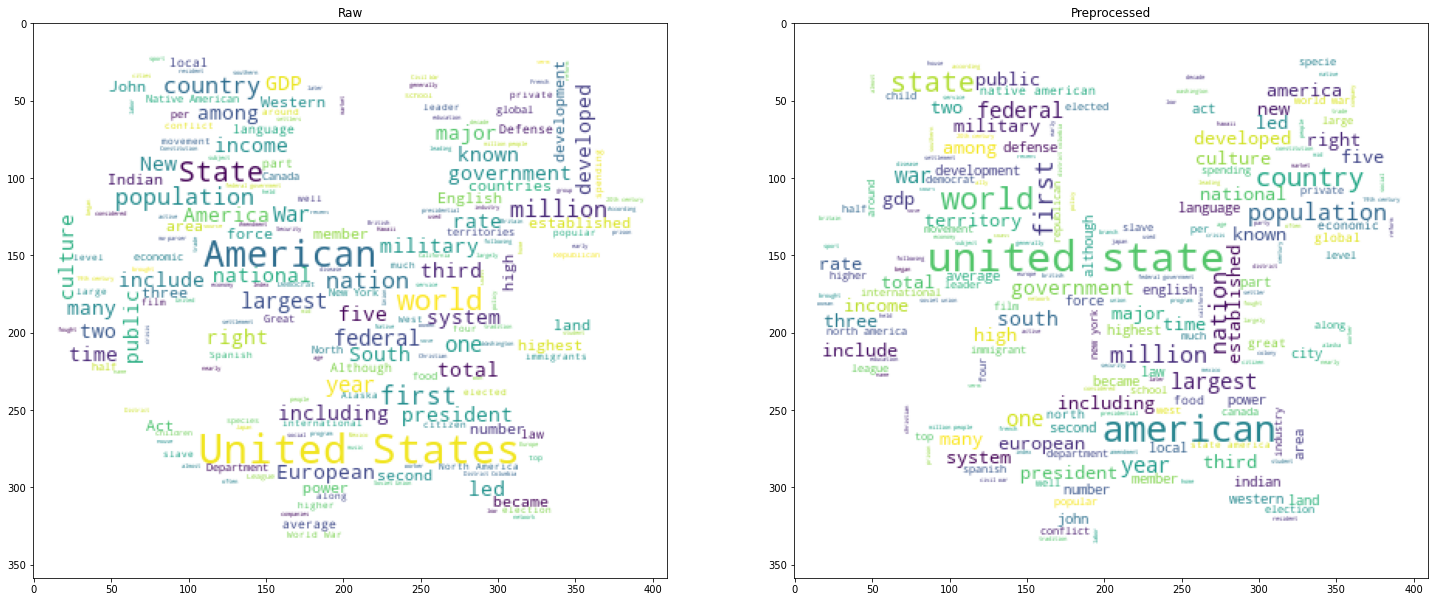

In [8]:
wc_mask = np.array(Image.open(urllib.request.urlopen("http://pm1.narvii.com/5750/abb7fdf1f24f9515a1f1d16e6f05d3f03110c51f_00.jpg")))
wc = WordCloud(background_color="white",mask=wc_mask)
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax[0].imshow(wc.generate(article_text))
ax[0].title.set_text("Raw")
ax[1].imshow(wc.generate(pp_string))
ax[1].title.set_text("Preprocessed")
plt.show()

## LSA Explore Input/Outputs

In [11]:
#1,1(unigrams only)  1,2(unigrams and bigrams) 2,2(bigrams only)
count_vectorizer = CountVectorizer(ngram_range=(1,1)) 
count_vectorizer.fit(pp_article_st)
X = count_vectorizer.transform(pp_article_st)

In [12]:
#perform Latent Semantic Analysis (LSA)
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100)

In [ ]:
U.shape #document-topic

(594, 10)

In [ ]:
VT.shape #topic-term

(10, 3136)

In [ ]:
SIGMA.shape # topic - topic sparse matrix

(10,)

In [ ]:
scores = np.sqrt(np.dot(U**2,SIGMA**2))

In [ ]:
scores.shape

(594,)

In [ ]:
#get index of highest scores
top_scores_index = np.argsort(scores)

In [ ]:
#sort the indexes in descending order
top_scores_index = top_scores_index[::-1]

In [ ]:
#get top N Scores index
top_scores_index = top_scores_index[0:N_LINE]

In [ ]:
top_scores_index

array([  0, 464, 447, 569, 274, 431, 470, 345,  11, 141])

In [ ]:
scores[top_scores_index]

array([15.07251127,  8.13742293,  7.06155453,  6.26265046,  5.96701386,
        4.49502756,  4.28935591,  4.28564734,  4.24658734,  4.20066484])

In [ ]:
article_array = np.array(article_st)

In [ ]:
bow_sum = article_array[top_scores_index]

In [ ]:
bow_sum = list(bow_sum)

In [ ]:
len(bow_sum)

10

In [ ]:
bow_sum_unigram = (" ").join(bow_sum)

In [ ]:
bow_sum_unigram

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. [424]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded by the cdc since 2003, the first overall decline since 2018, and "the largest one-year decline since world war ii." other languages spoken at home by one million people or more include chinese (2

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_vectorizer.fit(pp_article_st)
X = tfidf_vectorizer.transform(pp_article_st)

In [ ]:
#perform LSA
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) 

In [ ]:
U.shape #document-topic

(594, 10)

In [ ]:
VT.shape #topic-term

(10, 3136)

In [ ]:
SIGMA.shape # topic - topic sparse matrix

(10,)

In [ ]:
scores = np.sqrt(np.dot(U**2,SIGMA**2))

In [ ]:
scores.shape

(594,)

In [ ]:
#get index of highest scores
top_scores_index = np.argsort(scores)

In [ ]:
#sort the indexes in descending order
top_scores_index = top_scores_index[::-1]

In [ ]:
#get top N Scores index
top_scores_index = top_scores_index[0:N_LINE]

In [ ]:
top_scores_index

array([447, 301, 452, 255,  12, 263,  11, 253,  22,   4])

In [ ]:
scores[top_scores_index]

array([0.76573841, 0.74629242, 0.70641235, 0.67982507, 0.6771919 ,
       0.64933276, 0.62378055, 0.61224302, 0.59890548, 0.58791346])

In [ ]:
article_array = np.array(article_st)

In [ ]:
tfidf_sum = article_array[top_scores_index]

In [ ]:
tfidf_sum = list(tfidf_sum)

In [ ]:
len(tfidf_sum)

10

In [ ]:
tfidf_sum_unigram = (" ").join(tfidf_sum)

In [ ]:
tfidf_sum_unigram

"other languages spoken at home by one million people or more include chinese (2.8 million), tagalog (1.6 million), vietnamese (1.4 million), french (1.3 million), korean (1.1 million), and german (1 million). the united states is one of the few countries in the world to do so. the united states has the world's largest christian population. the district of columbia and the five major u.s. territories do not have senators. during the cold war, the united states fought the korean war and the vietnam war but avoided direct military conflict with the soviet union. [231] the states and the district of columbia choose the president of the united states. the spanish–american war and world war i established the u.s. as a world power, a status confirmed by the outcome of world war ii. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. by value, the united states is the world's largest importer and second-largest e

## TF-IDF LDA Unigram

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_vectorizer.fit(pp_article_st)
X = tfidf_vectorizer.transform(pp_article_st)
X.shape

(594, 3136)

In [ ]:
lda_model = LDA(n_components=N_LINE, random_state=0, max_iter = 50)
lda_model.fit(X)

LatentDirichletAllocation(max_iter=50, random_state=0)

In [ ]:
document_topic = lda_model.transform(X)
document_topic.shape #Document Topic

(594, 10)

In [ ]:
document_topic[0].sum()

0.9999999999999999

In [ ]:
vocab = np.array(tfidf_vectorizer.get_feature_names())
vocab.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(3136,)

In [ ]:
topic_word = lda_model.components_ # topic - word
topic_word.shape

(10, 3136)

In [ ]:
topic_word[0].shape

(3136,)

In [ ]:
top_features_indices = topic_word[0].argsort()[ : -10 - 1 : -1 ] # get indices by argsort() 

In [ ]:
top_features_indices.shape

(10,)

In [ ]:
top_features = vocab[top_features_indices] #alternateively: top_features = [vocab[i] for i in top_features_indices]
top_features

array(['european', 'american', 'state', 'language', 'united', 'war',
       'island', 'federal', 'also', 'government'], dtype='<U17')

In [ ]:
weights = topic_word[0][top_features_indices]
weights

array([2.00548944, 1.98251322, 1.9660667 , 1.9295343 , 1.76408511,
       1.63853085, 1.2762452 , 1.2557261 , 1.20747619, 1.17768905])

In [ ]:
## Generate Feaure Matrixes and Summaries For BI-GRAM (2-GRAM) Occurence

## Function to Generate BOW + LSA Summary

In [39]:
def generate_bow_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple)
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens)
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))
  top_scores_index = np.argsort(sentence_scores)[::-1]
  top_scores_index = top_scores_index[0:summary_size]
  article_array = np.array(raw_sent_tokens)
  bow_sum = list(article_array[top_scores_index])
  bow_sum_str = " ".join(bow_sum)
  return bow_sum_str

## Function to Generate TF-IDF + LSA Summary

In [43]:
def generate_tfidf_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple)
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens)
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))
  top_scores_index = np.argsort(sentence_scores)[::-1]
  top_scores_index = top_scores_index[0:summary_size]
  article_array = np.array(raw_sent_tokens)
  tfidf_sum = list(article_array[top_scores_index])
  tfidf_sum_str = " ".join(tfidf_sum)
  return tfidf_sum_str

## Number of Lines in Summary

In [53]:
N_LINE = 10

## Generate Feaure Matrixes and Summaries For Uni-GRAM (1-GRAM) Occurence

### LSA

#### BOW

In [74]:
bow_1gram_summary = generate_bow_summary(article_st, pp_article_st, N_LINE, (1,1))
bow_1gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. [421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded by the cdc since 2003, the first overall decline since 2018, and "the largest one-year decline since world war ii." other languages spoken at home by one million people or more include chinese (2

#### TF-IDF

In [75]:
tfidf_1gram_summary = generate_tfidf_summary(article_st, pp_article_st, N_LINE, (1,1))
tfidf_1gram_summary

"other languages spoken at home by one million people or more include chinese (2.8 million), tagalog (1.6 million), vietnamese (1.4 million), french (1.3 million), korean (1.1 million), and german (1 million). the united states is one of the few countries in the world to do so. the united states has the world's largest christian population. the spanish–american war and world war i established the u.s. as a world power. the district of columbia and the five major u.s. territories do not have senators. [231] the states and the district of columbia choose the president of the united states. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. by value, the united states is the world's largest importer and second-largest exporter of goods. [22] with a population of more than 331 million people, it is the third most populous country in the world. [213]\nthe united states is a federal republic of 50 states, a fed

#### Word-Embeddings

In [ ]:
w2v_model = Word2Vec(sentences=pp_article_st_wt,
                    min_count = 5, 
                    window = 5,
                    vector_size=10,
                    sample=6e-5,
                    alpha=0.001,
                    min_alpha = 0.0007,
                    negative=20,
                    workers=num_cores-2)

words = list(w2v_model.wv.index_to_key)
word_emb_list = sorted(words)

document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
dte_df = pd.DataFrame(document_term_emb)
dte_df.columns = word_emb_list
for i in range(len(pp_article_st)):
  freq_map = Counter(pp_article_st[i])
  for word in word_emb_list:
    if freq_map[word] > 0:
      dte_df[word].iloc[i] += np.median(w2v_model.wv[word])
      freq_map[word] -= 1
      
X = dte_df.to_numpy()
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
wemb_sum_unigram = article_array[top_scores_index] #get top N scoring sentences
wemb_sum_unigram = list(wemb_sum_unigram) #convert array back to list
print(f"Number of Lines in Summary: {len(wemb_sum_unigram)} \n")
wemb_sum_unigram = (" ").join(wemb_sum_unigram) #convert list to single string
wemb_sum_unigram      

Number of Lines in Summary: 10 



'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [360][361][362][363][364][365][366] in 2011, 16.7 million children lived in food-insecure households, about 35% more than 2007 levels, though only 845,000 u.s. children (1.1%) saw reduced food intake or disrupted eating patterns at some point during the year, and most cases were not chronic. of this area, 2,959,064 square miles (7,663,940\xa0km2) is contiguous land, composing 83.65% of total u.s. land area. [415] in a 2014 survey, 70.6% of adults in the united states identified themselves as christians;[416] protestants accounted for 46.5%, while catholics, at 20.8%, formed the largest single christian denomination. after a surge in female labor participation, especially in the 1970s, by 1985, the majority of women aged 16 and over were employed. [540]\n

### LDA

## Generate Feaure Matrixes and Summaries For BI-GRAM (2-GRAM) Occurence

### LSA

#### BOW

In [73]:
bow_2gram_summary = generate_bow_summary(article_st, pp_article_st, N_LINE, (2,2))
bow_2gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. [533] in soccer (a sport that has gained a footing in the united states since the mid-1990s), the country hosted the 1994 fifa world cup, the men\'s national soccer team qualified for ten world cups and the women\'s team has won the fifa women\'s world cup four times; major league soccer is the sport\'s highest league in the united states (featuring 23 american and three canadian teams). [421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy 

#### TF-IDF

In [72]:
tfidf_2gram_summary = generate_tfidf_summary(article_st, pp_article_st, N_LINE, (2,2))
tfidf_2gram_summary

"it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. it is a permanent member of the united nations security council. the district of columbia and the five major u.s. territories do not have senators. the united states is one of the few countries in the world to do so. by value, the united states is the world's largest importer and second-largest exporter of goods. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. [132][133]\nafter world war ii, the united states and the soviet union competed for power, influence, and prestige during what became known as the cold war, driven by an ideological divide between capitalism and communism. after imperial japan attacked pearl harbor in 1941 during world war ii, the united states joined the conflict on the side of the allies, with the aftermath leaving the united states and the soviet unio

#### Word-Embeddings

In [ ]:
bigram_transformer = Phrases(pp_article_st_wt)

In [ ]:
pp_article_st[1]

'consists 50 state federal district five major unincorporated territory 326 indian reservation minor possession'

In [ ]:
bigram_transformer[[pp_article_st[1]]]

['consists 50 state federal district five major unincorporated territory 326 indian reservation minor possession']

In [ ]:


w2v_model = Word2Vec(sentences=pp_article_st_wt,
                    min_count = 5, 
                    window = 5,
                    vector_size=10,
                    sample=6e-5,
                    alpha=0.001,
                    min_alpha = 0.0007,
                    negative=20,
                    workers=num_cores-2)

words = list(w2v_model.wv.index_to_key)
word_emb_list = sorted(words)

document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
dte_df = pd.DataFrame(document_term_emb)
dte_df.columns = word_emb_list
for i in range(len(pp_article_st)):
  freq_map = Counter(pp_article_st[i])
  for word in word_emb_list:
    if freq_map[word] > 0:
      dte_df[word].iloc[i] += np.median(w2v_model.wv[word])
      freq_map[word] -= 1
      
X = dte_df.to_numpy()
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
wemb_sum_bigram = article_array[top_scores_index] #get top N scoring sentences
wemb_sum_bigram = list(wemb_sum_bigram) #convert array back to list
print(f"Number of Lines in Summary: {len(wemb_sum_bigram)} \n")
wemb_sum_bigram = (" ").join(wemb_sum_bigram) #convert list to single string
wemb_sum_bigram      

Number of Lines in Summary: 10 



'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [360][361][362][363][364][365][366] in 2011, 16.7 million children lived in food-insecure households, about 35% more than 2007 levels, though only 845,000 u.s. children (1.1%) saw reduced food intake or disrupted eating patterns at some point during the year, and most cases were not chronic. of this area, 2,959,064 square miles (7,663,940\xa0km2) is contiguous land, composing 83.65% of total u.s. land area. [415] in a 2014 survey, 70.6% of adults in the united states identified themselves as christians;[416] protestants accounted for 46.5%, while catholics, at 20.8%, formed the largest single christian denomination. after a surge in female labor participation, especially in the 1970s, by 1985, the majority of women aged 16 and over were employed. [540]\n

## Generate Feaure Matrixes and Summaries For Tri-GRAM (3-GRAM) Occurence

### LSA

#### BOW

In [71]:
bow_3gram_summary = generate_bow_summary(article_st, pp_article_st, N_LINE, (3,3))
bow_3gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [421]\nthe centers for disease control and preventio

#### TF-IDF

In [70]:
tfidf_3gram_summary = generate_tfidf_summary(article_st, pp_article_st, N_LINE, (3,3))
tfidf_3gram_summary

"it is a permanent member of the united nations security council. it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. the district of columbia and the five major u.s. territories do not have senators. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. [548]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. the united states is one of the few countries in the world to do so. the united states has the world's largest christian population. [132][133]\nafter world war ii, the united states and the soviet union competed for power, influence, and prestige during what became known as the cold war, driven by an ideological divide between capitalism 

#### Word-Embeddings

In [ ]:
w2v_model = Word2Vec(sentences=pp_article_st_wt,
                    min_count = 5, 
                    window = 5,
                    vector_size=10,
                    sample=6e-5,
                    alpha=0.001,
                    min_alpha = 0.0007,
                    negative=20,
                    workers=num_cores-2)

words = list(w2v_model.wv.index_to_key)
word_emb_list = sorted(words)

document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
dte_df = pd.DataFrame(document_term_emb)
dte_df.columns = word_emb_list
for i in range(len(pp_article_st)):
  freq_map = Counter(pp_article_st[i])
  for word in word_emb_list:
    if freq_map[word] > 0:
      dte_df[word].iloc[i] += np.median(w2v_model.wv[word])
      freq_map[word] -= 1
      
X = dte_df.to_numpy()
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
wemb_sum_trigram = article_array[top_scores_index] #get top N scoring sentences
wemb_sum_trigram = list(wemb_sum_trigram) #convert array back to list
print(f"Number of Lines in Summary: {len(wemb_sum_trigram)} \n")
wemb_sum_trigram = (" ").join(wemb_sum_trigram) #convert list to single string
wemb_sum_trigram      

## Generate Feaure Matrixes and Summaries For (4-GRAM) Occurence

### LSA

#### BOW

In [69]:
bow_4gram_summary = generate_bow_summary(article_st, pp_article_st, N_LINE, (4,4))
bow_4gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [421]\nthe centers for disease control and preventio

#### TF-IDF

In [68]:
tfidf_4gram_summary = generate_tfidf_summary(article_st, pp_article_st, N_LINE, (4,4))
tfidf_4gram_summary

'it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. it is a permanent member of the united nations security council. the district of columbia and the five major u.s. territories do not have senators. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. [548]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. [213]\nthe united states is a federal republic of 50 states, a federal district, five territories and several uninhabited island possessions. it consists of 50 states, a federal district, five major unincorporated territories, 326 indian reservations, and some minor possessions. paleo-indians migrated from siberia to the north american mai

## Generate Feaure Matrixes and Summaries For (5-GRAM) Occurence

### LSA

#### BOW

In [66]:
bow_5gram_summary = generate_bow_summary(article_st, pp_article_st, N_LINE, (5,5))
bow_5gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [421]\nthe centers for disease control and preventio

#### TF-IDF

In [67]:
tfidf_5gram_summary = generate_tfidf_summary(article_st, pp_article_st, N_LINE, (5,5))
tfidf_5gram_summary

'it is a permanent member of the united nations security council. it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. the district of columbia and the five major u.s. territories do not have senators. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. [548]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. [213]\nthe united states is a federal republic of 50 states, a federal district, five territories and several uninhabited island possessions. it consists of 50 states, a federal district, five major unincorporated territories, 326 indian reservations, and some minor possessions. paleo-indians migrated from siberia to the north american mai

## Summaries Generated Via Survery

In [76]:
survey_summary1 = """The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. By value, the United States is the world's largest importer and the second-largest exporter of goods. Although its population is only 4.2% of the world total, it holds 29.4% of the total wealth in the world, the largest share held by any country.Americans had developed an ideology of "republicanism", asserting that government rested on the will of the people as expressed in their local legislatures. Americans have traditionally been characterized by a strong work ethic, competitiveness, and individualism,[455] as well as a unifying belief in an "American creed" emphasizing liberty, equality, private property, democracy, rule of law, and a preference for limited government. The country has received criticism in regard to inequality related to race, wealth and income, the use of capital punishment, high incarceration rates, and lack of universal health care. In 2018, there were almost 90 million immigrants and U.S.-born children of immigrants in the United States, accounting for 28% of the overall U.S. population. The country is one of the five recognized nuclear weapons states and one of nine countries to possess nuclear weapons. The American fast food industry, the world's largest, pioneered the drive-through format in the 1940s. American football is by several measures the most popular spectator sport in the United States."""
survey_summary1

'The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. By value, the United States is the world\'s largest importer and the second-largest exporter of goods. Although its population is only 4.2% of the world total, it holds 29.4% of the total wealth in the world, the largest share held by any country.Americans had developed an ideology of "republicanism", asserting that government rested on the will of the people as expressed in their local legislatures. Americans have traditionally been characterized by a strong work ethic, competitiveness, and individualism,[455] as well as a unifying belief in an "American creed" emphasizing liberty, equality, private property, democracy, rule of law, and a preference for limited government. The country has received criticism in regard to inequality related to race, wealth and income, the use of capital punishment, high incarceration rates, and lack of un

In [77]:
survey_summary2 = """The United States of America (USA), commonly known as the United States (U.S. or US), or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major self-governing territories, 326 Indian reservations, and some minor possessions. At 3.8 million square miles (9.8 million square kilometers), it is the world's third- or fourth-largest country by total area. With a population of more than 328 million people, it is the third most populous country in the world. Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago, and European colonization began in the 16th century. The United States emerged from the thirteen British colonies established along the East Coast. In the late 18th century, the U.S. began vigorously expanding across North America, gradually acquiring new territories, frequently displacing Native Americans, and admitting new states; by 1848, the United States spanned the continent. The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. The United States is a highly developed country, and continuously ranks high in measures of socioeconomic performance. Making up more than a third of global military spending, it is the foremost military power in the world and is a leading political, cultural, and scientific force internationally. """
survey_summary2

"The United States of America (USA), commonly known as the United States (U.S. or US), or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major self-governing territories, 326 Indian reservations, and some minor possessions. At 3.8 million square miles (9.8 million square kilometers), it is the world's third- or fourth-largest country by total area. With a population of more than 328 million people, it is the third most populous country in the world. Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago, and European colonization began in the 16th century. The United States emerged from the thirteen British colonies established along the East Coast. In the late 18th century, the U.S. began vigorously expanding across North America, gradually acquiring new territories, frequently displacing Native Americans, and admitting new states; by 1848, the United States spanned the continent. The U

## Evaluation of Generated Summaries using ROUGE-N Metric and Survey Summary 2

## Function to evaluate N-gram summary

In [84]:
def get_ngram_rouge(ngram, generated_summary, survey_summary):
  scorer = rouge_scorer.RougeScorer([f'rouge{ngram}'], use_stemmer=False)
  scores = scorer.score(generated_summary, survey_summary)[f"rouge{ngram}"]
  return scores

### 1-GRAM

In [82]:
bow_1gram_rouge = get_ngram_rouge(1, bow_1gram_summary, survey_summary2)
bow_1gram_rouge

Score(precision=0.5087719298245614, recall=0.19965576592082615, fmeasure=0.2867737948084054)

In [94]:
tfidf_1gram_rouge = get_ngram_rouge(1, tfidf_1gram_summary, survey_summary2)
tfidf_1gram_rouge

Score(precision=0.42543859649122806, recall=0.5132275132275133, fmeasure=0.46522781774580335)

### 2-GRAM

In [86]:
bow_2gram_rouge = get_ngram_rouge(2, bow_2gram_summary, survey_summary2)
bow_2gram_rouge

Score(precision=0.18502202643171806, recall=0.06471494607087827, fmeasure=0.0958904109589041)

In [93]:
tfidf_2gram_rouge = get_ngram_rouge(2, tfidf_2gram_summary, survey_summary2)
tfidf_2gram_rouge

Score(precision=0.13656387665198239, recall=0.14418604651162792, fmeasure=0.14027149321266968)

### 3-GRAM

In [90]:
bow_3gram_rouge = get_ngram_rouge(3, bow_3gram_summary, survey_summary2)
bow_3gram_rouge

Score(precision=0.12831858407079647, recall=0.042709867452135494, fmeasure=0.06408839779005525)

In [92]:
tfidf_3gram_rouge = get_ngram_rouge(3, tfidf_3gram_summary, survey_summary2)
tfidf_3gram_rouge

Score(precision=0.04424778761061947, recall=0.04504504504504504, fmeasure=0.04464285714285714)

### 4-GRAM

In [97]:
bow_4gram_rouge = get_ngram_rouge(4, bow_4gram_summary, survey_summary2)
bow_4gram_rouge

Score(precision=0.08888888888888889, recall=0.029585798816568046, fmeasure=0.04439511653718091)

In [98]:
tfidf_4gram_rouge = get_ngram_rouge(4, tfidf_4gram_summary, survey_summary2)
tfidf_4gram_rouge

Score(precision=0.16444444444444445, recall=0.17209302325581396, fmeasure=0.1681818181818182)

### 5-GRAM

In [101]:
bow_5gram_rouge = get_ngram_rouge(5, bow_5gram_summary, survey_summary2)
bow_5gram_rouge

Score(precision=0.08035714285714286, recall=0.026587887740029542, fmeasure=0.039955604883462816)

In [102]:
tfidf_5gram_rouge = get_ngram_rouge(5, tfidf_5gram_summary, survey_summary2)
tfidf_5gram_rouge

Score(precision=0.14732142857142858, recall=0.1542056074766355, fmeasure=0.1506849315068493)

<h2> Comparision of N-GRAM and Feature Extraction Scheme Using ROUGE-N Recall Scores </h2>  

In [107]:
comparision_df = pd.DataFrame()
comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]
comparision_df["BOW"] = [bow_1gram_rouge.recall, bow_2gram_rouge.recall, bow_3gram_rouge.recall, bow_4gram_rouge.recall, bow_5gram_rouge.recall]
comparision_df["TF-IDF"] = [tfidf_1gram_rouge.recall, tfidf_2gram_rouge.recall, tfidf_3gram_rouge.recall, tfidf_4gram_rouge.recall, tfidf_5gram_rouge.recall]
comparision_df

,N-Gram Range,BOW,TF-IDF
0,1-Gram,0.064715,0.513228
1,2-Gram,0.064715,0.144186
2,3-Gram,0.042710,0.045045
3,4-Gram,0.029586,0.172093
4,5-Gram,0.026588,0.154206


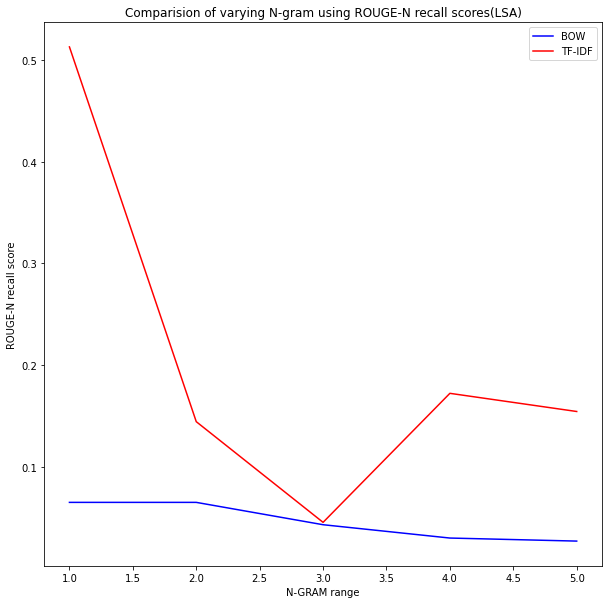

In [108]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

n_gram_range = [i for i in range(1,6)]

ax.plot(n_gram_range,comparision_df["BOW"],"b-")
ax.plot(n_gram_range,comparision_df["TF-IDF"],"r-")

ax.title.set_text("Comparision of varying N-gram using ROUGE-N recall scores(LSA)")
ax.set_xlabel("N-GRAM range")
ax.set_ylabel("ROUGE-N recall score")

plt.legend(["BOW", "TF-IDF"])

plt.show()

## Generate Features using Word-Embeddings (Next On Line)

In [ ]:
pp_article_st[0:3]

['coordinate mw parser output geo default mw parser output geo dm mw parser output geo dec display inline mw parser output geo nondefault mw parser output geo multi punct display none mw parser output longitude mw parser output latitude white space nowrap 40 n 100 w 40 n 100 w 40 100the united state america u usa commonly known united state u u america country primarily located north america',
 'consists 50 state federal district five major unincorporated territory 326 indian reservation minor possession',
 '3 8 million square mile 9 8 million square kilometer world third fourth largest country total area']

In [ ]:
pp_article_st_wt = [word_tokenize(sent) for sent in pp_article_st]

In [ ]:
#initialize word to vec
w2v_model = Word2Vec(min_count = 5, 
                     window = 5,
                     vector_size=10,
                     sample=6e-5,
                     alpha=0.001,
                     min_alpha = 0.0007,
                     negative=10,
                     workers=num_cores-2)

In [ ]:
w2v_model.build_vocab(pp_article_st_wt,progress_per=10000)

In [ ]:
w2v_model.build_vocab(pp_article_st_wt,progress_per=10000)
w2v_model.train(pp_article_st_wt, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)


(0, 0)

In [ ]:
w2v_model.train(pp_article_st_wt, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)

(0, 0)

In [ ]:
#see embeddings for gas
w2v_model.wv["gas"]

array([ 0.05382323, -0.08485057, -0.01655645, -0.08838222, -0.01641879,
        0.05655618, -0.07418299,  0.05510068,  0.06090059, -0.0377048 ],
      dtype=float32)

In [ ]:
print(w2v_model.wv.vectors.shape)

(396, 10)


In [ ]:
EMBEDDING_SIZE = w2v_model.wv.vectors.shape

In [ ]:

w2v_model.wv["state"]

array([-0.08619688,  0.03665738,  0.05189884,  0.05741937,  0.07466917,
       -0.06167676,  0.01105614,  0.06047282, -0.02840052, -0.06173522],
      dtype=float32)

In [ ]:
#w2v_model.wv.key_to_index

In [ ]:
type(w2v_model.wv.key_to_index)

dict

In [ ]:
#if "state" in w2v_model.wv.key_to_index:
#    print("Yes")

In [ ]:
w2v_model.wv["gas"]

array([ 0.05382323, -0.08485057, -0.01655645, -0.08838222, -0.01641879,
        0.05655618, -0.07418299,  0.05510068,  0.06090059, -0.0377048 ],
      dtype=float32)

In [ ]:
np.average(w2v_model.wv["gas"])

-0.009171514

In [ ]:

w2v_model.build_vocab(pp_article_st_wt,progress_per=10000)
w2v_model.train(pp_article_st_wt, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)
words = list(w2v_model.wv.index_to_key)
word_emb_list = sorted(words)
document_term_emb = np.zeros(shape=(len(pp_article_st), len(word_emb_list)))
dte_df = pd.DataFrame(document_term_emb)
dte_df.columns = word_emb_list
for i in range(len(pp_article_st)):
  freq_map = Counter(pp_article_st[i])
  for word in word_emb_list:
    if freq_map[word] > 0:
      dte_df[word].iloc[i] = np.average(w2v_model.wv[word])
      freq_map[word] -= 1



## Create Scikit learn pipe line --> from sklearn.pipeline import Pipeline:-->preprocessing-->BOW/TFIDF/WordEmbeddings/----> LSA/LDA

In [ ]:
#inputgiven documents---->
input_document = ["I am enjoying this movie",
"We cannot go from here to there at any time"]

#given embeddings of words:
#hashed acess already exists

#create feature vector


In [ ]:
#we_df = pd.DataFrame(np.zeros(shape=(len(pp_article_st), len(word_emb_list))))
#we_df.columns = word_emb_list

In [ ]:
"""
def generate_embedding_vector(single_sentence):
    word_tokens = word_tokenize(single_sentence)
"""

'\ndef generate_embedding_vector(single_sentence):\n    word_tokens = word_tokenize(single_sentence)\n'

In [ ]:
#array of size word 2 vec
#features word_emb_list
document_term_emb = np.zeros(shape=(len(pp_article_st), len(word_emb_list)))
dte_df = pd.DataFrame(document_term_emb)
dte_df.columns = word_emb_list
for i in range(len(pp_article_st)):
  freq_map = Counter(pp_article_st[i])
  for word in word_emb_list:
    if freq_map[word] > 0:
      dte_df[word].iloc[i] = np.average(w2v_model.wv[word])
      freq_map[word] -= 1


In [ ]:
dte_df.head(10)

,0,000,1,10,100,12,14,15,16,17,1776,18,18th,19th_century,2,20,2010,2011,2016,2017,2018,2019,2020,2021,20th_century,23,24,28,3,4,40,5,50,6,7,8,9,according,across,act,...,television,term,territory,third,thirteen,though,three,throughout,time,took,top,total,trade,tradition,trillion,two,u,union,united,united_state,university,used,value,vote,w,war,washington,wave,wealth,well,west,western,white,woman,work,worker,world,world_war,would,year
0,0.00163,0.0,0.03156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.027198,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00163,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.008825,0.000000,0.0,0.014984,0.0,0.008896,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.008825,0.000000,0.0,0.000000,0.0,0.000000,0.000000,-0.019334,0.041695,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.03156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.008825,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.00163,0.0,0.03156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.008896,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.00000,0.0,0.03156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.008825,0.000000,0.0,0.014984,0.0,0.000000,0.004718,-0.019334,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.00000,0.0,0.03156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.

In [ ]:
pp_article_st[0:10]

['coordinate mw parser output geo default mw parser output geo dm mw parser output geo dec display inline mw parser output geo nondefault mw parser output geo multi punct display none mw parser output longitude mw parser output latitude white space nowrap 40 n 100 w 40 n 100 w 40 100the united state america u usa commonly known united state u u america country primarily located north america',
 'consists 50 state federal district five major unincorporated territory 326 indian reservation minor possession',
 '3 8 million square mile 9 8 million square kilometer world third fourth largest country total area',
 'united state share significant land border canada north mexico south well limited maritime border bahamas cuba russia',
 'population 331 million people third populous country world',
 'national capital washington c populous city new york city',
 'paleo indian migrated siberia north american mainland least 12 000 year ago european colonization began 16th century',
 'united state em

In [ ]:
for i in range(len(pp_article_st)):
  freq_map = Counter(pp_article_st[i])
  for word in word_emb_list:
    if freq_map[word] > 0:
      dte_df[word].iloc[i] += np.average(w2v_model.wv[word])
      freq_map[word] -= 1

In [ ]:
X = dte_df.to_numpy()
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
bow_sum = article_array[top_scores_index] #get top N scoring sentences
bow_sum = list(bow_sum) #convert array back to list
print(f"Number of Lines in Summary: {len(bow_sum)} \n")
bow_sum_unigram = (" ").join(bow_sum) #convert list to single string
bow_sum_unigram

Number of Lines in Summary: 10 



'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [540]\nin 1998, the number of u.s. commercial radio stations had grown to 4,793 am stations and 5,662 fm stations. [86] the 1803 louisiana purchase almost doubled the nation\'s area,[87] spain ceded florida and other gulf coast territory in 1819,[88] the republic of texas was annexed in 1845 during a period of expansionism,[89] and the 1846 oregon treaty with britain led to u.s. control of the present-day american northwest. [424]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded by the cdc since

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=False)
score_1gram_tfidf = scorer.score(bow_sum_unigram,survey_summary2)["rouge1"].recall #TF-IDF
score_1gram_tfidf

0.18631178707224336

In [ ]:
bigram_transformer = Phrases(pp_article_st_wt)
w2v_model = Word2Vec(bigram_transformer[pp_article_st_wt],
                    min_count = 5, 
                    window = 5,
                    vector_size=10,
                    sample=6e-5,
                    alpha=0.001,
                    min_alpha = 0.0007,
                    negative=10,
                    workers=num_cores-2)
words = list(w2v_model.wv.index_to_key)
word_emb_list = sorted(words)

document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
dte_df = pd.DataFrame(document_term_emb)
dte_df.columns = word_emb_list
for i in range(len(pp_article_st)):
  freq_map = Counter(pp_article_st[i])
  for word in word_emb_list:
    if freq_map[word] > 0:
      dte_df[word].iloc[i] += np.median(w2v_model.wv[word])
      freq_map[word] -= 1
      
X = dte_df.to_numpy()
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
bow_sum = article_array[top_scores_index] #get top N scoring sentences
bow_sum = list(bow_sum) #convert array back to list
print(f"Number of Lines in Summary: {len(bow_sum)} \n")
bow_sum_unigram = (" ").join(bow_sum) #convert list to single string
bow_sum_unigram      

In [ ]:
X = dte_df.to_numpy()
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
bow_sum = article_array[top_scores_index] #get top N scoring sentences
bow_sum = list(bow_sum) #convert array back to list
print(f"Number of Lines in Summary: {len(bow_sum)} \n")
bow_sum_unigram = (" ").join(bow_sum) #convert list to single string
bow_sum_unigram

Number of Lines in Summary: 10 



'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [540]\nin 1998, the number of u.s. commercial radio stations had grown to 4,793 am stations and 5,662 fm stations. [86] the 1803 louisiana purchase almost doubled the nation\'s area,[87] spain ceded florida and other gulf coast territory in 1819,[88] the republic of texas was annexed in 1845 during a period of expansionism,[89] and the 1846 oregon treaty with britain led to u.s. control of the present-day american northwest. since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=False)
score_1gram_tfidf = scorer.score(bow_sum_unigram,survey_summary2)["rouge2"].fmeasure #TF-IDF
score_1gram_tfidf

0.03723404255319149

## Reevalaute if word embeddings were generated properly (see if they were cumulated rather than, updated....  medain might work better than average...... see if the embedings can be generated as probabilites ...exponent or softmax or something)